<a href="https://colab.research.google.com/github/EyberRosero/Analitica-De-Datos/blob/master/Punto_2_Red_Profunda_y_Amplia_(Fashion_MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construyendo un clasificador de imágenes con una Red Profunda y Amplia

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

Esta función sirve para graficar la Matriz de Confusion para comprobar la eficiencia del clasificador

In [2]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues): 
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax    

Comencemos cargando el conjunto de datos **Fashion MNIST**. Keras tiene una serie de funciones para cargar conjuntos de datos populares en *keras.datasets*. 
- El conjunto de datos ya está dividido entre un **conjunto de entrenamiento** ``X_train`` y un **conjunto de prueba** ``X_test``:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


El **conjunto de entrenamiento** contiene 60,000 imágenes en escala de grises, cada una de $28\times 28$ píxeles:

In [4]:
X_train.shape

(60000, 28, 28)

Cada intensidad de píxel se representa como un byte (0 a 255) entonces **escalamos las intensidades de píxeles hasta el rango 0-1** y las convertimos en flotantes, dividiéndolas por 255.

In [5]:
X_train = X_train/ 255.
X_test = X_test / 255.

###Agregando salida extra **Datos con etiquetas Femenino, Masculino y Unisex**

In [6]:
# Etiquetas de clases

#   0 unisex
#   1 unisex
#   4 unisex
#   9 unisex

#   2 hombre
#   6 hombre
#   7 hombre

#   3 mujer
#   5 mujer
#   8 mujer


ytrainGEN = np.zeros((y_train.shape[0]))
ytestGEN = np.zeros((y_test.shape[0]))

ytrainGEN[y_train == 0] = 2 #unisex
ytrainGEN[y_train == 1] = 2 #unisex
ytrainGEN[y_train == 4] = 2 #unisex
ytrainGEN[y_train == 9] = 2 #unisex

ytrainGEN[y_train == 2] = 0 #masculino
ytrainGEN[y_train == 6] = 0 #masculino
ytrainGEN[y_train == 7] = 0 #masculino

ytrainGEN[y_train == 3] = 1 #femenino
ytrainGEN[y_train == 5] = 1 #femenino
ytrainGEN[y_train == 8] = 1 #femenino

ytestGEN[y_test == 0] = 2 #unisex
ytestGEN[y_test == 1] = 2 #unisex
ytestGEN[y_test == 4] = 2 #unisex
ytestGEN[y_test == 9] = 2 #unisex

ytestGEN[y_test == 2] = 0 #masculino
ytestGEN[y_test == 6] = 0 #masculino
ytestGEN[y_test == 7] = 0 #masculino

ytestGEN[y_test == 3] = 1 #femenino
ytestGEN[y_test == 5] = 1 #femenino
ytestGEN[y_test == 8] = 1 #femenino


  
ytrainGEN = ytrainGEN.astype(int)
ytestGEN = ytestGEN.astype(int)

###Agregando entrada extra **Datos con ruido blanco gaussiano y varianza 0.1**

In [7]:
#agregar entrada extra 
var = 0.1 #varianza ruido
XtrainB = X_train + np.sqrt(var)*np.random.randn(X_train.shape[0],X_train.shape[1],X_train.shape[2])
XtestB = X_test + np.sqrt(var)*np.random.randn(X_test.shape[0],X_test.shape[1],X_test.shape[2])

###Agregando entrada extra **Datos con ruido sal y pimienta a un snr de 0.9**

In [8]:
def addsalt_pepper(xtrain, SNR):
  XtrainC = xtrain.copy()
  c, h, w = XtrainC.shape
  mask = np.random.choice((0, 1, 2), size=(1, h, w), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
  mask = np.repeat(mask, c, axis=0) # Copy by channel to have the same shape as img
  XtrainC[mask == 1] = 1 # salt noise
  XtrainC[mask == 2] = 0 # 
  return XtrainC

#Agregando entrada con ruido sal y pimienta a un snr de 0.9
XtrainC = addsalt_pepper(X_train,0.9)
XtestC = addsalt_pepper(X_test,0.9)

Aquí están los nombres de clase correspondientes a los datos:

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


Echemos un vistazo a una muestra de las imágenes de la **Entrada A**:

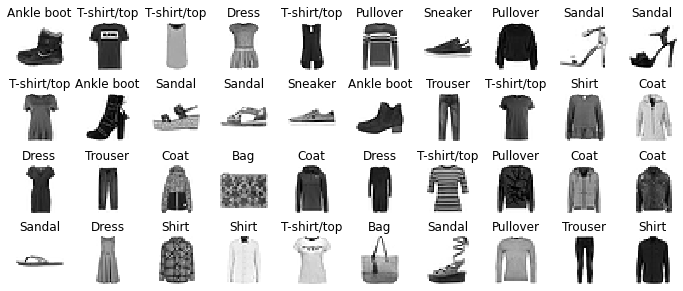

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

Echemos un vistazo a una muestra de las imágenes de la **Entrada B** (Ruido blanco):

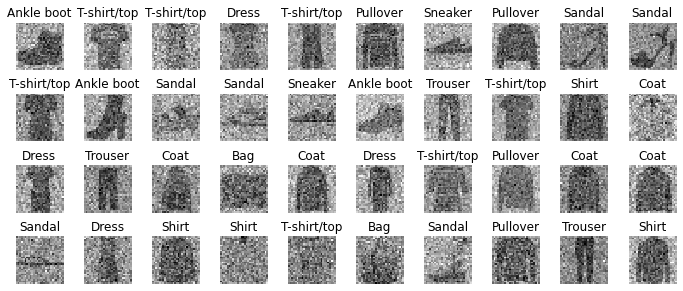

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(XtrainB[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

Echemos un vistazo a una muestra de las imágenes de la **Entrada C** (Ruido sal y pimienta):

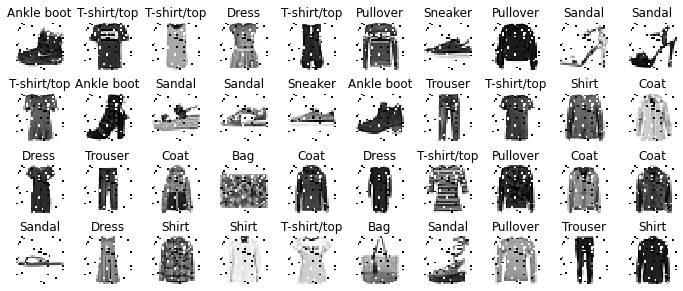

In [12]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(XtrainC[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Crear el modelo usando la API funcional

¡Ahora construyamos la red neuronal! 

In [13]:

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Modelo funcional
inputA = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2],1),name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2],1),name='entradaB')
inputC = tf.keras.layers.Input(shape=(XtrainC.shape[1],XtrainC.shape[2],1),name='entradaC')

'''
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
'''
#DefaultConv2D = partial(keras.layers.Conv2D,kernel_size=3, activation='relu', padding="SAME")

Q1=100
Q2=20
l1=1e-3
l2=1e-3

Conv1A = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME")(inputA)
Conv2A = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME")(inputB)
Conv3A = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME")(inputC)

Pol1A = keras.layers.MaxPooling2D(pool_size=2)(Conv1A)
Pol2A = keras.layers.MaxPooling2D(pool_size=2)(Conv2A)
Pol3A = keras.layers.MaxPooling2D(pool_size=2)(Conv3A)

'''
Conv1B=DefaultConv2D(filters=128)(Pol1A)
Conv2B=DefaultConv2D(filters=128)(Pol2A)
Conv3B=DefaultConv2D(filters=128)(Pol3A)

Conv1C=DefaultConv2D(filters=128)(Conv1B)
Conv2C=DefaultConv2D(filters=128)(Conv2B)
Conv3C=DefaultConv2D(filters=128)(Conv3B)

Pol1D = keras.layers.MaxPooling2D(pool_size=2)(Conv1C)
Pol2D = keras.layers.MaxPooling2D(pool_size=2)(Conv2C)
Pol3D = keras.layers.MaxPooling2D(pool_size=2)(Conv3C)
'''

flattenA = tf.keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2]))(Pol1A)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(Pol2A)
flattenC = tf.keras.layers.Flatten(input_shape=(XtrainC.shape[1],XtrainC.shape[2]))(Pol3A)



h1A = tf.keras.layers.Dense(Q1,activation='tanh',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(Q1,activation='tanh',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)                            
h1C = tf.keras.layers.Dense(Q1,activation='tanh',name='h1C',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenC)

h2A = tf.keras.layers.Dense(Q2,activation='tanh',name='h2A', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1A)
h2B = tf.keras.layers.Dense(Q2,activation='tanh',name='h2B', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1B)
h2C = tf.keras.layers.Dense(Q2,activation='tanh',name='h2C', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1C)      

conABC = tf.keras.layers.concatenate([h2A,h2B,h2C],name='conABC')      

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outABC1')(conABC) #salida multiclase
outputB = tf.keras.layers.Dense(3,activation="softmax",name='outABC2')(conABC) #salida multiclase

model_fun = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=[outputA,outputB])
model_fun.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
entradaC (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         entradaA[0][0]                   
______________________________________________________________________________________________

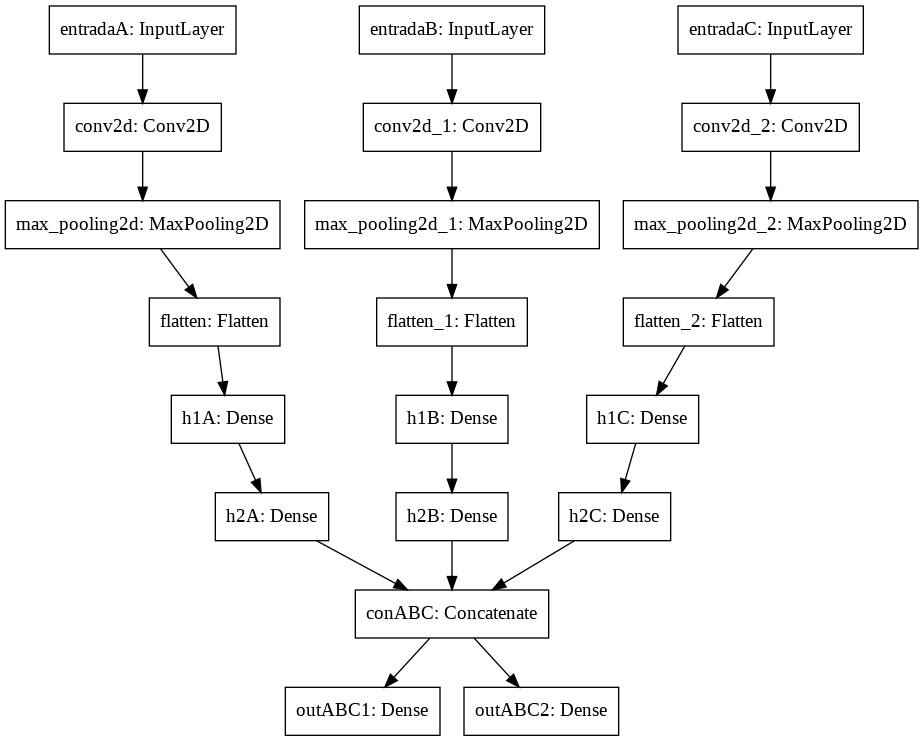

In [14]:
tf.keras.utils.plot_model(model_fun)

### Compilando el modelo
Después de crear un modelo, debe llamar a su método *compile()* para especificar la función de pérdida y el optimizador a utilizar. Opcionalmente, también puede especificar una lista de métricas adicionales para calcular durante el entrenamiento y la evaluación:

In [15]:
model_fun.compile(loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"], #derivar por dentro
                  loss_weights = [0.5,0.5],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"]) #monitorear medida de desempeño (solo para ver)

## Entrenando y evaluando el modelo
Ahora el modelo está listo para ser entrenado. Para esto, simplemente necesitamos llamar a su método *fit()*. 
- Le pasamos las características de entrada (X_train) y las clases de destino (y_train), así como la cantidad de épocas para entrenar (o de lo contrario, sería predeterminado a solo 1, lo que definitivamente no sería suficiente para converger en una buena solución). 
- También pasamos un conjunto de validación (esto es opcional): Keras medirá la pérdida y las métricas adicionales en este conjunto al final de cada época, lo cual es muy útil para ver qué tan bien se desempeña realmente el modelo.
- **NOTA:** si el rendimiento en el entrenamiento es mucho mejor que en el conjunto de validación, su modelo probablemente esté sobreajustando el conjunto de entrenamiento (o hay un error, como una falta de coincidencia de datos entre el conjunto de entrenamiento y el conjunto de validación):

In [16]:
history = model_fun.fit(x=[X_train,XtrainB,XtrainC], 
                        y=[y_train,ytrainGEN], 
                        epochs=30,
                        batch_size=256,
                        validation_split=0.3)

Epoch 1/30
165/165 [==============================] - 7s 40ms/step - loss: 4.9708 - outABC1_loss: 1.0424 - outABC2_loss: 0.7327 - outABC1_accuracy: 0.6709 - outABC2_accuracy: 0.6886 - val_loss: 1.8756 - val_outABC1_loss: 0.8383 - val_outABC2_loss: 0.8102 - val_outABC1_accuracy: 0.7262 - val_outABC2_accuracy: 0.6623
Epoch 2/30
165/165 [==============================] - 6s 36ms/step - loss: 1.4496 - outABC1_loss: 0.6856 - outABC2_loss: 0.5172 - outABC1_accuracy: 0.7646 - outABC2_accuracy: 0.7938 - val_loss: 1.3054 - val_outABC1_loss: 0.6356 - val_outABC2_loss: 0.5394 - val_outABC1_accuracy: 0.7779 - val_outABC2_accuracy: 0.7513
Epoch 3/30
165/165 [==============================] - 6s 36ms/step - loss: 1.1854 - outABC1_loss: 0.5971 - outABC2_loss: 0.4441 - outABC1_accuracy: 0.7915 - outABC2_accuracy: 0.8238 - val_loss: 1.2514 - val_outABC1_loss: 0.6665 - val_outABC2_loss: 0.5611 - val_outABC1_accuracy: 0.7586 - val_outABC2_accuracy: 0.7477
Epoch 4/30
165/165 [=============================

Puede ver que la **pérdida de entrenamiento se redujo**, lo cual es una buena señal, y la precisión de validación alcanzó el $88.28\%$ después de 30 épocas, no muy lejos de la precisión del entrenamiento, por lo que no parece haber demasiado ajuste.

El método *fit()* devuelve un objeto **history** que contiene: 
1. los parámetros de entrenamiento (*history.params*), 
2. la lista de épocas por las que pasó (*history.epoch*) y, 
3. lo más importante, un diccionario (*history.history*) que contiene la pérdida y las métricas adicionales que midió al final de cada época en el conjunto de entrenamiento y en el conjunto de validación (si corresponde). 

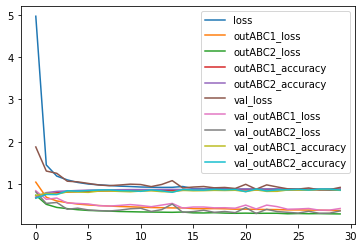

<function matplotlib.pyplot.show>

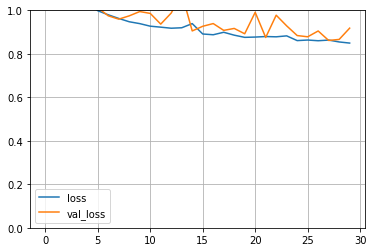

In [17]:
import pandas as pd

hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show


In [18]:
ytest_e,ytest_eB = model_fun.predict([X_test,XtestB,XtestC])
print(ytest_e.shape)
print(classification_report(y_test, ytest_e.argmax(axis=1)))

print(ytest_eB.shape)
print(np.unique(np.round(ytest_eB)))
print(classification_report(ytestGEN, ytest_eB.argmax(axis=1)))

(10000, 10)
              precision    recall  f1-score   support

           0       0.91      0.57      0.70      1000
           1       0.99      0.94      0.97      1000
           2       0.82      0.65      0.72      1000
           3       0.83      0.89      0.86      1000
           4       0.80      0.72      0.76      1000
           5       0.97      0.94      0.95      1000
           6       0.49      0.80      0.61      1000
           7       0.94      0.85      0.90      1000
           8       0.94      0.96      0.95      1000
           9       0.87      0.97      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.86      0.83      0.83     10000
weighted avg       0.86      0.83      0.83     10000

(10000, 3)
[0. 1.]
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      3000
           1       0.90      0.94      0.92      3000
           2       0.91      0.74      0.82    

Text(0.5, 1.0, 'Genero de Prendas')

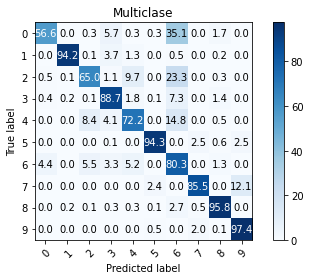

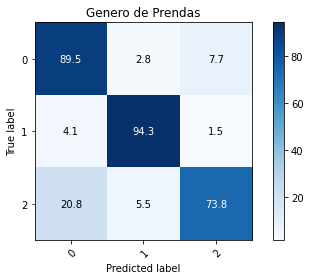

In [19]:
plot_confusion_matrix(y_test, ytest_e.argmax(axis=1),classes=np.unique(y_test))
plt.title('Multiclase')
plot_confusion_matrix(ytestGEN, ytest_eB.argmax(axis=1),classes=np.unique(y_test))
plt.title('Genero de Prendas')

# Interpretar pesos red

In [27]:
#crear nuevo modelo con salida parcial
model_cka = tf.keras.Model(inputs=inputA,outputs=model_fun.get_layer('h1A').output)
tf.keras.utils.plot_model(model_cka)
zcka = model_cka.predict(X_train)

In [28]:
from sklearn.decomposition import PCA
red = PCA()

zzcka = red.fit_transform(zcka)

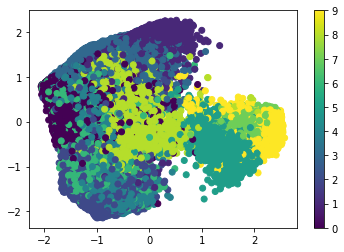

In [29]:
plt.scatter(zzcka[:,0],zzcka[:,1],c=y_train)
plt.colorbar()
plt.show()

In [30]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

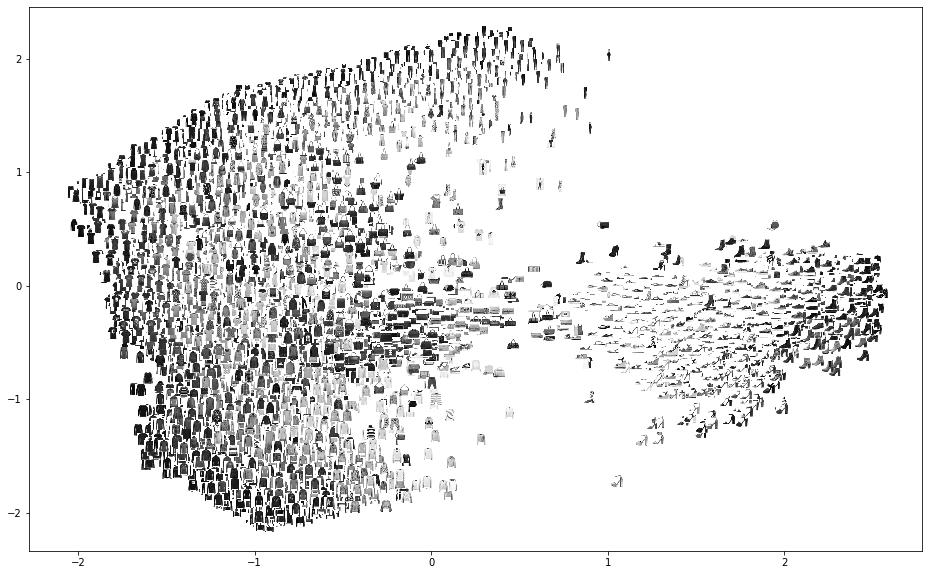

In [31]:
Ni =10000
ind = np.random.randint(0,y_train.shape[0],Ni)
plot_mnist_2d(zzcka[ind],y_train[ind],X_train[ind],img_w=28,img_h=28,zoom=0.4,cmap='binary')

In [32]:
#crear nuevo modelo con salida parcial
model_cka = tf.keras.Model(inputs=inputA,outputs=model_fun.get_layer('h2A').output)
tf.keras.utils.plot_model(model_cka)
zcka = model_cka.predict(X_train)

In [33]:
from sklearn.decomposition import PCA
red = PCA()

zzcka = red.fit_transform(zcka)

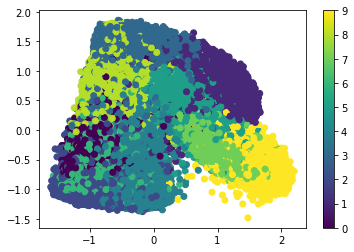

In [34]:
plt.scatter(zzcka[:,0],zzcka[:,1],c=y_train)
plt.colorbar()
plt.show()

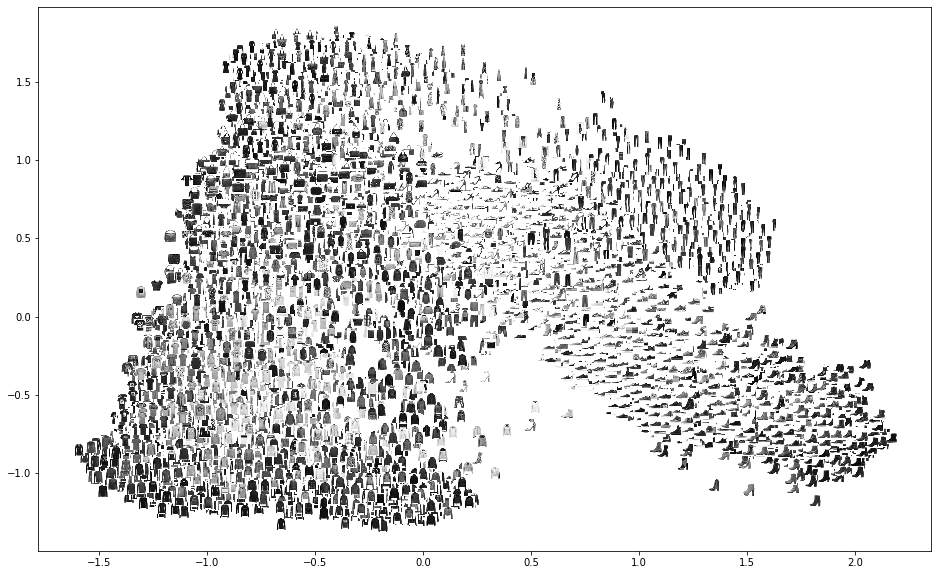

In [35]:
Ni =10000
ind = np.random.randint(0,y_train.shape[0],Ni)
plot_mnist_2d(zzcka[ind],y_train[ind],X_train[ind],img_w=28,img_h=28,zoom=0.4,cmap='binary')

Una vez que esté **satisfecho con la precisión de validación de su modelo**, debe evaluarla en el *conjunto de prueba* para estimar el error de generalización antes de implementar el modelo en producción:

- Como vimos anteriormente, es **común obtener un rendimiento ligeramente inferior en el conjunto de prueba** que en el conjunto de validación, porque los hiperparámetros están sintonizados en el conjunto de validación, no en el conjunto de prueba (*sin embargo, en este ejemplo, no lo hicimos cualquier ajuste de hiperparámetro, por lo que la precisión más baja es solo mala suerte*).

## Usando el modelo para hacer predicciones
A continuación, podemos usar el método *predict()* del modelo para hacer predicciones sobre nuevas instancias. Como no tenemos instancias nuevas reales, solo usaremos las primeras 3 instancias del **conjunto de prueba**:

5 [[0. 1. 0.]]


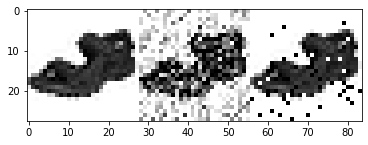

In [40]:
ii = 502
pe,peb = model_fun.predict([X_test[ii][np.newaxis,:,:],XtestB[ii][np.newaxis,:,:],XtestC[ii][np.newaxis,:,:]])
print(pe.argmax(),np.round(peb))
plt.imshow(np.c_[X_test[ii],XtestB[ii],XtestC[ii]],cmap='binary',vmin=0,vmax=1)
plt.show()